# Audio Freeze Effect using AR model

This goal of this notebook is to walk through the separate steps that are needed to recreate an audio freeze effect using an autoregressive process model and IIR filtering operation.

In [1]:
import numpy as np
import fastburg as burg
import scipy.signal
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from IPython.display import Audio
%matplotlib inline

### Parameters

The `freeze_pos` is the position from where the extrapolation starts. `prediction_lenght` is the duration in samples which should be extrapolated/filled by the algorithm.

In [2]:
audio_input = "data/trumpet.wav"
freeze_pos = 44100
prediction_length = 44100 * 5

In [3]:
def ar_freeze(
    samples,
    pos,      # sample position where freeze is started
    dur,      # number of samples to extrapolate
    n=4000,   # AR order
    ns=4000,  # number of samples to adapt on
):
    # create buffer
    outBuffer = np.zeros(dur, np.float)

    # filter identification
    a = np.real(
        burg._arburg2(samples[pos - ns - 1:pos], n)[0]
    )

    # compute initial filter states
    z = scipy.signal.lfiltic([1.0], a, samples[pos-(np.arange(1, n+1))])
    
    # set initial states (zi) of all-pole filter and exite filter with zeros
    outBuffer, z = scipy.signal.lfilter(
        [1.0], a, np.zeros(dur, np.float), zi=z
    )
    return np.concatenate((samples[:pos], outBuffer))

### Read and plot spectrogram

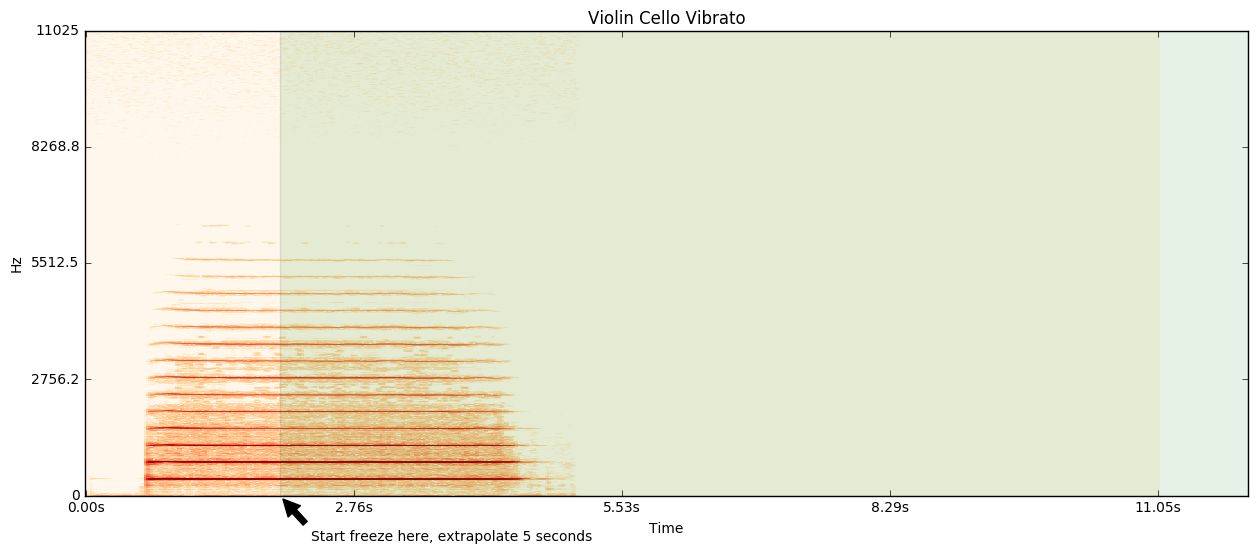

In [4]:
samples, rate = sf.read(audio_input)
# add some zeros
samples = np.concatenate([samples, np.zeros(rate*3)])
# compute STFT
D = librosa.logamplitude(np.abs(librosa.stft(samples))**2, ref_power=np.max)
# Show spectrogram
f = plt.figure(figsize=(15, 6))
ax = plt.subplot(111)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title('Trumpet Sample')
p = plt.axvspan(
        librosa.samples_to_frames(freeze_pos), 
        librosa.samples_to_frames(freeze_pos + prediction_length), 
        facecolor='g', 
        alpha=0.1
)

ax.annotate(
    'Start freeze here, extrapolate 5 seconds', xy=(librosa.samples_to_frames(freeze_pos), 0), 
    xytext=(100, -100), arrowprops=dict(facecolor='black', shrink=0.1),
)
Audio(samples, rate=rate)  

### Fit AR model and plot AR coefficients (n=100)

In [5]:
def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    
    Code from: https://www.dsprelated.com/showcode/244.php
    Copyright (c) 2011 Christopher Felton
    """

    # get a figure/plot
    f = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    
    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black')
    ax.add_patch(uc)

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=4.0, markeredgewidth=0.5,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)


    plt.show()

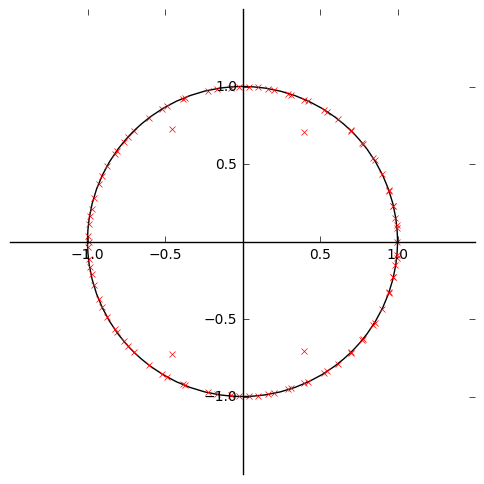

In [6]:
# filter identification
a = np.real(
    burg._arburg2(samples[freeze_pos - 100 - 1:freeze_pos], 100)[0]
)

# show poles on unit circle
zplane([1], a)

## Freeze (filter order n=1000)

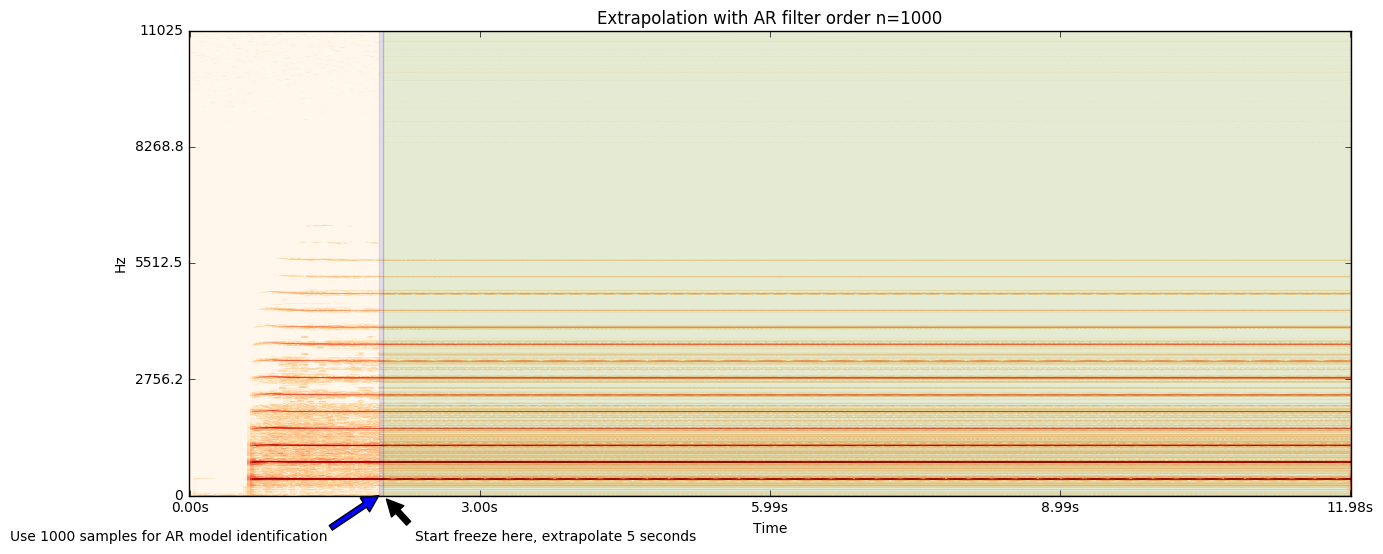

In [7]:
# compute extrapolation
freeze_n1000 = ar_freeze(samples, pos=freeze_pos, dur=prediction_length, n=1000, ns=1000)

# plot spectrogram
D = librosa.logamplitude(np.abs(librosa.stft(freeze_n1000))**2, ref_power=np.max)
f = plt.figure(figsize=(15, 6))
librosa.display.specshow(D, y_axis='linear', x_axis='time')
ax = plt.subplot(111)
plt.title('Extrapolation with AR filter order n=1000')
plt.axvspan(
    librosa.samples_to_frames(freeze_pos), 
    librosa.samples_to_frames(freeze_pos + prediction_length), 
    facecolor='g', 
    alpha=0.1
)
ax.annotate(
    'Start freeze here, extrapolate 5 seconds', xy=(librosa.samples_to_frames(freeze_pos), 0), 
    xytext=(100, -100), arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axvspan(
    librosa.samples_to_frames(freeze_pos-1000), 
    librosa.samples_to_frames(freeze_pos), 
    facecolor='b', 
    alpha=0.1
)
ax.annotate(
    'Use 1000 samples for AR model identification', xy=(librosa.samples_to_frames(freeze_pos - 1000), 0), 
    xytext=(-80, -100), arrowprops=dict(facecolor='b'),
)
Audio(freeze_n1000, rate=rate)  

## Freeze (filter order n=4000)

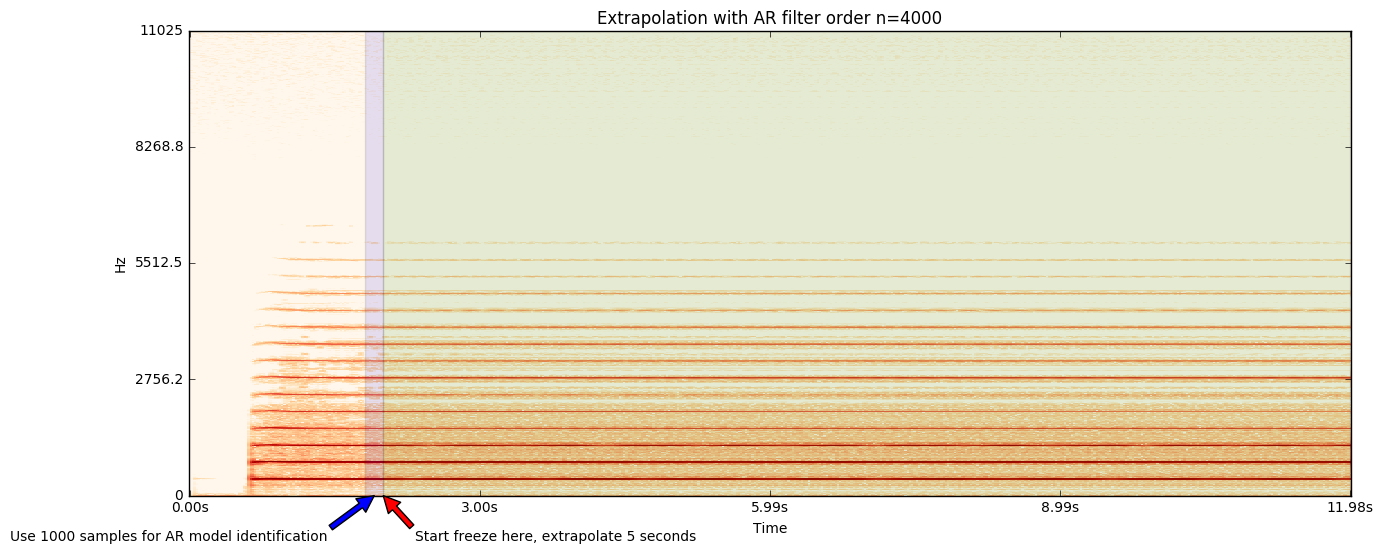

In [8]:
freeze_n4000 = ar_freeze(samples, pos=freeze_pos, dur=prediction_length, n=4000, ns=4000)
D = librosa.logamplitude(np.abs(librosa.stft(freeze_n4000))**2, ref_power=np.max)
f = plt.figure(figsize=(15, 6))
ax = plt.subplot(111)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title('Extrapolation with AR filter order n=4000')
p = plt.axvspan(
        librosa.samples_to_frames(freeze_pos), 
        librosa.samples_to_frames(freeze_pos + prediction_length), 
        facecolor='g', 
        alpha=0.1
)
ax.annotate(
    'Start freeze here, extrapolate 5 seconds', xy=(librosa.samples_to_frames(freeze_pos), 0), 
    xytext=(100, -100), arrowprops=dict(facecolor='r'),
)
plt.axvspan(
    librosa.samples_to_frames(freeze_pos-4000), 
    librosa.samples_to_frames(freeze_pos), 
    facecolor='b', 
    alpha=0.1
)
ax.annotate(
    'Use 1000 samples for AR model identification', xy=(librosa.samples_to_frames(freeze_pos - 4000/2), 0), 
    xytext=(-80, -100), arrowprops=dict(facecolor='b'),
)
Audio(freeze_n4000, rate=rate)

## Freeze (filter order n=16000)

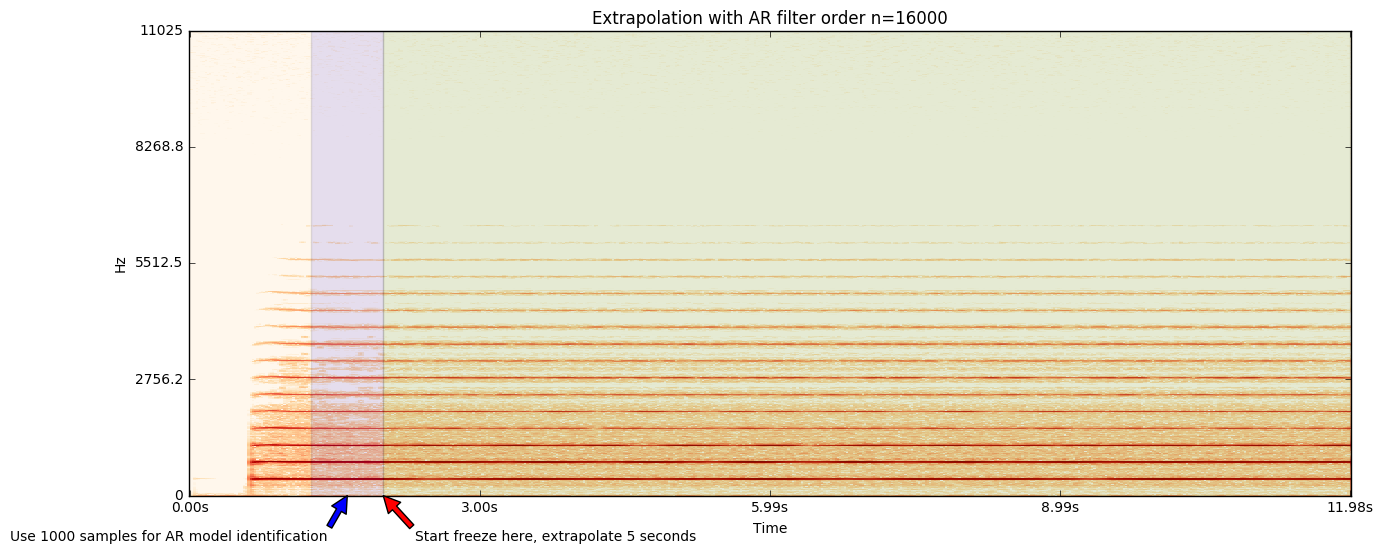

In [9]:
freeze_n16000 = ar_freeze(samples, pos=freeze_pos, dur=prediction_length, n=16000, ns=16000)
D = librosa.logamplitude(np.abs(librosa.stft(freeze_n16000))**2, ref_power=np.max)
f = plt.figure(figsize=(15, 6))
ax = plt.subplot(111)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title('Extrapolation with AR filter order n=16000')
plt.axvspan(
    librosa.samples_to_frames(freeze_pos), 
    librosa.samples_to_frames(freeze_pos + prediction_length), 
    facecolor='g', 
    alpha=0.1
)
ax.annotate(
    'Start freeze here, extrapolate 5 seconds', xy=(librosa.samples_to_frames(freeze_pos), 0), 
    xytext=(100, -100), arrowprops=dict(facecolor='r'),
)
plt.axvspan(
    librosa.samples_to_frames(freeze_pos-16000), 
    librosa.samples_to_frames(freeze_pos), 
    facecolor='b', 
    alpha=0.1
)
ax.annotate(
    'Use 1000 samples for AR model identification', xy=(librosa.samples_to_frames(freeze_pos - 16000/2), 0), 
    xytext=(-80, -100), arrowprops=dict(facecolor='b'),
)
Audio(freeze_n16000, rate=rate)

## Filter order smaller than number of samples for adapation

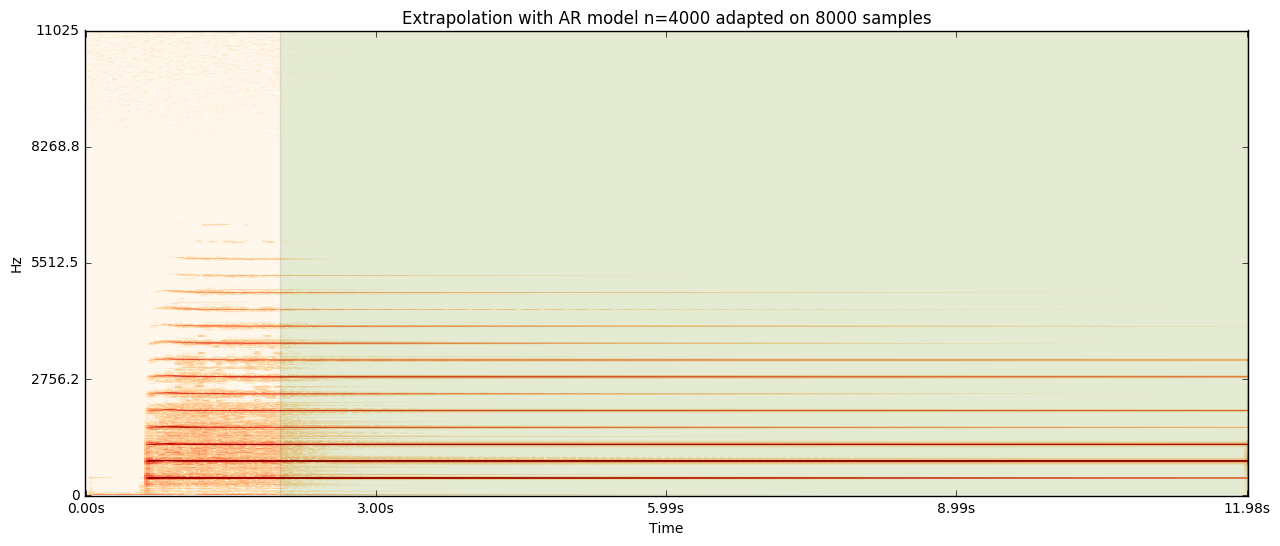

In [12]:
freeze_n = ar_freeze(samples, pos=freeze_pos, dur=prediction_length, n=4000, ns=8000)
D = librosa.logamplitude(np.abs(librosa.stft(freeze_n))**2, ref_power=np.max)
f = plt.figure(figsize=(15, 6))
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title('Extrapolation with AR model n=4000 adapted on 8000 samples')
p = plt.axvspan(
        librosa.samples_to_frames(freeze_pos), 
        librosa.samples_to_frames(freeze_pos + prediction_length), 
        facecolor='g', 
        alpha=0.1
)
Audio(freeze_n, rate=rate)